## 패키지 선언

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader

## Dataset 선언

In [ ]:
# Training dataset 다운로드
mnist_train = dataset.MNIST(root = "./" , # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
mnist_test = dataset.MNIST(root = './',
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 52288928.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1829402.17it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 14171414.92it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4762632.19it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## MNIST 데이터셋 형상 확인

60000
torch.Size([1, 28, 28])
5


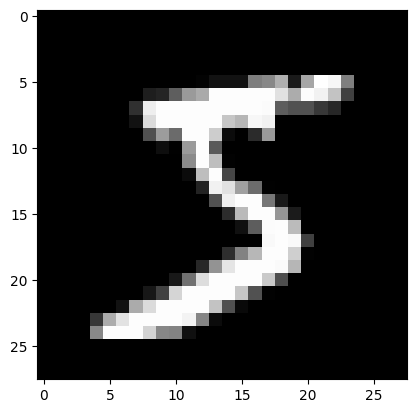

In [ ]:
import matplotlib.pyplot as plt
print(len(mnist_train))     # training dataset 개수 확인

first_data = mnist_train[0]
print(first_data[0].shape)  # 첫번째 data의 형상 확인
print(first_data[1] )        # 첫번째 data의 정답 확인

plt.imshow(first_data[0][0,:,:], cmap='gray')
plt.show()

In [ ]:
first_img = first_data[0]
print(first_img.shape)

# view(): 평탄화 시키는 함수 - SLP클래스 안에서 사용됨
first_img = first_img.view(-1, 28*28) # 이미지 평탄화 수행 2D -> 1D
print(first_img.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


## Single Layer Perceptron 모델 정의

In [ ]:
class SLP (nn.Module):
  def __init__ (self):
    super(SLP, self).__init__()
    # SLP의 입력노드은 784개, 출력노드는 10개
    # 참고: torch.nn.Linear = Fully connected layer
    self.fc1 = nn.Linear(in_features=784, out_features=10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 28*28) # 이미지 평탄화
    y = self.relu(self.fc1(x))

    return y

## Hyper-parameters 지정

### 참고: torch.nn.CrossEntropyLoss()
1. 예측 값들에 대해 자동으로 softmax 적용: 여러 개의 입력을 받아 각각의 확률 값으로 출력
2. 정답 값과 예측 값을 이용해 cross entropy loss 측정
- small batch size: 자주 모델이 업데이트->모델이 더 잘 일반화됨. 하지만, 계산 시간이 김.
-  big batch size: 적은 횟수로 업데이트->더 빠른 계산을 가능. 하지만, 일반화 성능이 떨어질 수 있음.

In [ ]:
batch_size = 32                        # 한번에 학습할 데이터의 개수
learning_rate = 0.1                     # 가중치를 얼마나 변경시킬지 정하는 상수
training_epochs = 40                   # 학습 횟수(1 Epoch: 전체 데이터셋에 대해 1회 학습)
loss_function = nn.CrossEntropyLoss()   # 학습 모델이 얼마나 잘못 예측하고 있는지는 표현하는 지표, nn에 접근가능

# network의 하위 파라미터들(weight, bias)
# network.fc.weight
# network.fc.weight.grad
# network.fc.bias
# network.fc.bias.grad
network = SLP()   # nn을 매개변수로 받음

# Optimizer: SGD - Loss function을 최소로 만들기 위한 가중치, 편향을 찾는 알고리즘 - 파라미터 넘겨주는 걸로 정의됨
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# Perceptron 학습을 위한 반복문 선언

In [ ]:
# 6만개의 이미지를 한번에 넣기에는 너무 많음
# 그래서 배치 사이즈만큼 나눠서 한번에 32개의 이미지를 훈련시키는 과정을 총 1875번해서 6만개의 이미지를 훈련시킴
# training_epochs를 통해 위 과정을 40번 함
# 따라서 파라미터들이 업데이트 되는 횟수: 32 x 60000/32개 x 40 번
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)


  for img, label in data_loader:

    # SLP클래스의 forward함수가 실행됨
    pred = network(img)

    # 예측 값, 정답을 이용해 loss 계산
    loss = loss_function(pred, label)

    # 기울기를 저장하는 network.fc.weight.grad 속성의 값을 0으로 설정
    # 기울기를 저장하는 network.fc.bias.grad 속성의 값을 0으로 설정
    # cf) 각 배치마다 따로 기울기를 계산해야되서, 안해주면 각 배치에 대해 누적됨
    optimizer.zero_grad()   # 파리미터들의 gradient 초기화(weight, bias)

    # 각 파라미터들의 grad속성에 편미분 통해 얻은 gradient를 저장
    loss.backward()   # 모든 weight와 bias에 대해 편미분 값 계산

    # weight, bias 업데이트
    # w의 기울기가 음수라는 건 x축 기준으로 기울기가 0이 되는 x값보다 작으므로 -1을 곱해서 w에 특정비율만큼 더해주는 것임
    # w의 기울기가 양수라는 건 x축 기준으로 기울기가 0이 되는 x값보다 크므로 -1을 곱해서 w에 특정비율만큼 빼주는 것임
    # weight = weight − (learning_rate × weight.grad)
    # bias = bias − (learning_rate × bias.grad)
    optimizer.step()    # 각 파라미터에 대해 저장된 기울기를 사용하여 파라미터를 업데이트

    avg_cost += loss / total_batch    # 모든 배치에 대한 평균 loss값 계산

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Epoch: 1 Loss = 0.414293
Epoch: 2 Loss = 0.313692
Epoch: 3 Loss = 0.296879
Epoch: 4 Loss = 0.287632
Epoch: 5 Loss = 0.281834
Epoch: 6 Loss = 0.277065
Epoch: 7 Loss = 0.274139
Epoch: 8 Loss = 0.271543
Epoch: 9 Loss = 0.269075
Epoch: 10 Loss = 0.266753
Epoch: 11 Loss = 0.265182
Epoch: 12 Loss = 0.263595
Epoch: 13 Loss = 0.262429
Epoch: 14 Loss = 0.260957
Epoch: 15 Loss = 0.259879
Epoch: 16 Loss = 0.259272
Epoch: 17 Loss = 0.258011
Epoch: 18 Loss = 0.257133
Epoch: 19 Loss = 0.256629
Epoch: 20 Loss = 0.255514
Epoch: 21 Loss = 0.254808
Epoch: 22 Loss = 0.254136
Epoch: 23 Loss = 0.253285
Epoch: 24 Loss = 0.252704
Epoch: 25 Loss = 0.252493
Epoch: 26 Loss = 0.251824
Epoch: 27 Loss = 0.251392
Epoch: 28 Loss = 0.250876
Epoch: 29 Loss = 0.249956
Epoch: 30 Loss = 0.249839
Epoch: 31 Loss = 0.249535
Epoch: 32 Loss = 0.248592
Epoch: 33 Loss = 0.248594
Epoch: 34 Loss = 0.248324
Epoch: 35 Loss = 0.247509
Epoch: 36 Loss = 0.247447
Epoch: 37 Loss = 0.247314
Epoch: 38 Loss = 0.246501
Epoch: 39 Loss = 0.24

## 학습이 완료된 모델을 이용해 정답률 확인

In [ ]:
with torch.no_grad(): # test에서는 기울기 제외

  img_test = mnist_test.data.float()
  label_test = mnist_test.targets

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.8697999715805054


## Weight parameter 저장하기/불러오기

In [ ]:
torch.save(network.state_dict(), "./slp_mnist.pth")

## 결과값
### 1.
- self.fc1 = nn.Linear(in_features=784, out_features=10)
- batch_size = 100
- training_epochs = 15
> Accuracy: 0.8906999826431274